<a href="https://colab.research.google.com/github/akashe/ProgrammingInterview/blob/main/Programming_test_for_HappyMonk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assumptions in this test:
1. I am free to choose network size and optimize activation function AF on that.
2. I am also free to choose param dimensions for $k_o$ and $k_1$



In [1]:
import torch
import gzip
import os
import sys
import struct
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.distributions.normal import Normal
from torch.optim import Adam,SGD
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np

#### Dataset

We will be learning activation function on MNIST. Though google colab already has MNIST data but it has only 20k examples in train set. We will work with the 
full train set.

In [2]:
!wget -N https://data.deepai.org/mnist.zip

--2021-05-19 16:33:16--  https://data.deepai.org/mnist.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘mnist.zip’ not modified on server. Omitting download.



In [3]:
!unzip -n /content/mnist.zip

Archive:  /content/mnist.zip


In [4]:
# Loading data into tensors

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)


train_x=torch.from_numpy(read_image(gzip.open('train-images-idx3-ubyte.gz', 'rb')))
train_y=torch.from_numpy(read_label(gzip.open('train-labels-idx1-ubyte.gz', 'rb'))).long()
test_x=torch.from_numpy(read_image(gzip.open('t10k-images-idx3-ubyte.gz', 'rb')))
test_y=torch.from_numpy(read_label(gzip.open('t10k-labels-idx1-ubyte.gz', 'rb'))).long()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)


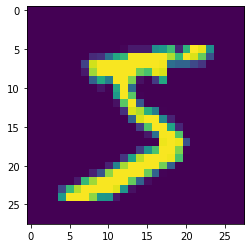

In [5]:
plt.imshow(  train_x[0]  )

In [6]:
# Reshaping x values
train_x = train_x.reshape(train_x.shape[0],-1)
test_x  = test_x.reshape(test_x.shape[0],-1)

#### Model

##### Activation Function:

Our activation functions will be sampling from a Normal distribution. We will use reparameterization trick to use them in our model. So,

$ k_0 = \mu_0 + \sigma_0*\mathcal{N}(0,1)$

$ k_1 = \mu_1 + \sigma_1*\mathcal{N}(0,1)$

Our activation function,

$g(x) = k_0 + k_1*x$
, where $*$ is pointwise multiplication

At t=0, 

$\mu_0=\mu_1=0$, and

$\sigma_0=\sigma_1=1$ 

Network:


In [7]:
class Activation_Function(nn.Module):
  def __init__(self,distribution='Normal'):
    super().__init__()
    
    # Setting up distribution
    if distribution== 'Normal':
      self.distribution = Normal(torch.tensor([0.0]),torch.tensor([1.0]))
    else:
      raise NotImplementedError
    
    # Defining values
    self.mu_zero = nn.Parameter(torch.zeros(1,requires_grad=True))
    self.mu_one = nn.Parameter(torch.zeros(1,requires_grad=True))
    self.sigma_zero = nn.Parameter(torch.ones(1,requires_grad=True))
    self.sigma_one = nn.Parameter(torch.ones(1,requires_grad=True))

  def forward(self, input_):
    # k_zero value after sampling
    k_zero = self.mu_zero + self.sigma_zero*self.distribution.rsample()

    # k_one value after sampling
    k_one = self.mu_one + self.sigma_one*self.distribution.rsample()

    return k_zero + k_one*input_

  def sample_k(self):
    with torch.no_grad():
      # k_zero value after sampling
      k_zero = self.mu_zero + self.sigma_zero*self.distribution.sample()

      # k_one value after sampling
      k_one = self.mu_one + self.sigma_one*self.distribution.sample()

    return k_zero, k_one

##### Network
Our network is a simple 3 layer neural network. With layer as following:
0. Input layer: [,784]
1. Layer 1 : Linear [784,128]
2. Layer 2: Linear [128,64]
3. Layer 3 : Linear [64,10]

Layer 3 is followed by CrossEntropyLoss()


In [8]:
class Network(nn.Module):
  def __init__(self,layer_dims):
    super().__init__()
    self.layers = []

    # Setting activation fucntion to our custom class
    self.activation =  Activation_Function()

    # Adding layers
    for i in range(1,len(layer_dims)):
      self.layers.append(nn.Linear(layer_dims[i-1],layer_dims[i],bias= True))
      if i != len(layer_dims)-1:
        self.layers.append(self.activation) 

    # Defining network 
    self.network = nn.Sequential(*self.layers)

    # Setting loss function
    self.loss = nn.CrossEntropyLoss()
    
  def forward(self,inputs_,labels_):
    outputs_ = self.network(inputs_)

    acc_ = sum(torch.argmax(outputs_,-1)==labels_)/len(inputs_)*100

    return self.loss(outputs_, labels_),acc_


#### Training loop

In [9]:
# Training variables
epochs = 20
batch_size = 128
layer_dims = [784,128,64,10]
lr = 0.05


# Initiate model
model = Network(layer_dims)

# Optimizer
optim = SGD(model.parameters(),lr=lr)

# Variables for plotting
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
k_zero = []
k_one = []


# Runner loop
for i in range(epochs):
  # Variables for prompt
  epoch_train_loss = []
  epoch_train_acc = []
  epoch_test_loss = []
  epoch_test_acc = []

  # Setting model to Train
  # model.train() 
  for j in range(0,int(len(train_x)/batch_size)):
    batch_x = train_x[j*batch_size:(j+1)*batch_size]
    batch_y = train_y[j*batch_size:(j+1)*batch_size]

    # sampling k_0 and k_1 values
    k_zero_, k_one_ = model.activation.sample_k()
    k_zero.append(k_zero_)
    k_one.append(k_one_)

    # setting grads to zero
    optim.zero_grad()

    # running the batch
    loss, acc = model(batch_x,batch_y)

    # backpropagating loss
    loss.backward()

    # optimizer step
    optim.step()

    # appending loss and acc values
    epoch_train_loss.append(loss.item())
    epoch_train_acc.append(acc)
    train_loss.append(loss.item())
    train_accuracy.append(acc)


  # Setting model to Test
  # model.eval()
  for j in range(0,int(len(test_x)/batch_size)):
    batch_x = test_x[j*batch_size:(j+1)*batch_size]
    batch_y = test_y[j*batch_size:(j+1)*batch_size]

    # running the batch
    with torch.no_grad():
      loss, acc = model(batch_x,batch_y)

    # appending loss and acc values
    epoch_test_loss.append(loss.item())
    epoch_test_acc.append(acc)
    test_loss.append(loss.item())
    test_accuracy.append(acc)

  print(f'Epoch {i}: \n Train loss= {sum(epoch_train_loss)/len(epoch_train_loss):.4f} \t Train Accuracy = {sum(epoch_train_acc)/len(epoch_train_acc):.4f} \
  \n Test loss = {sum(epoch_test_loss)/len(epoch_test_loss):.4f} \t Test Accuracy = {sum(epoch_test_acc)/len(epoch_test_acc):.4f}')

    

Epoch 0: 
 Train loss= 2.3115 	 Train Accuracy = 11.6319   
 Test loss = 2.2926 	 Test Accuracy = 14.5833
Epoch 1: 
 Train loss= 2.3040 	 Train Accuracy = 11.0110   
 Test loss = 2.3024 	 Test Accuracy = 11.8990
Epoch 2: 
 Train loss= 2.3026 	 Train Accuracy = 11.1528   
 Test loss = 2.3017 	 Test Accuracy = 11.5184
Epoch 3: 
 Train loss= 2.2977 	 Train Accuracy = 12.9324   
 Test loss = 2.2313 	 Test Accuracy = 37.4800
Epoch 4: 
 Train loss= 0.5417 	 Train Accuracy = 85.5803   
 Test loss = 0.3743 	 Test Accuracy = 88.7019
Epoch 5: 
 Train loss= 0.3167 	 Train Accuracy = 90.9505   
 Test loss = 0.3499 	 Test Accuracy = 89.3429
Epoch 6: 
 Train loss= 0.3007 	 Train Accuracy = 91.4463   
 Test loss = 0.3407 	 Test Accuracy = 89.7336
Epoch 7: 
 Train loss= 0.2920 	 Train Accuracy = 91.7201   
 Test loss = 0.3318 	 Test Accuracy = 89.9539
Epoch 8: 
 Train loss= 0.2861 	 Train Accuracy = 91.8904   
 Test loss = 0.3285 	 Test Accuracy = 90.1142
Epoch 9: 
 Train loss= 0.2816 	 Train Accuracy

#### Plots

##### k_zero and k_one

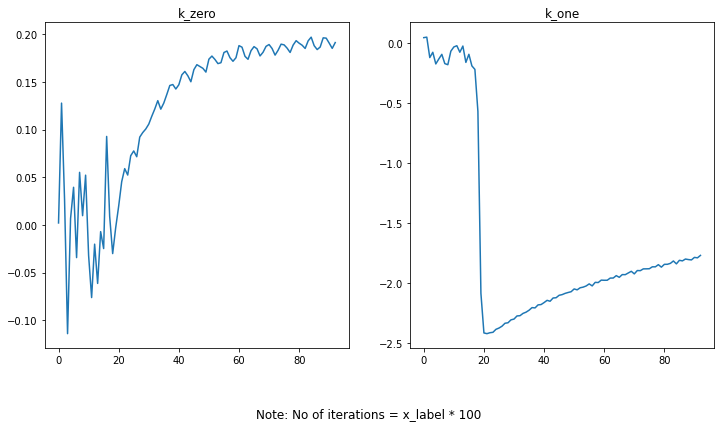

In [10]:
smooth_count = 100

def average_over(a,iterations_count=100):
  # Function to get smoother graphs by getting average values for every iteration count
  averaged_list = []
  i = 0
  while i+iterations_count < len(a):
    averaged_list.append(sum(a[i:i+iterations_count])/iterations_count)
    i += iterations_count
  
  return averaged_list



fig,ax = plt.subplots(ncols=2,figsize=(12,6))
fig.suptitle("Value of activation constants over time")
fig.suptitle(f'Note: No of iterations = x_label * {smooth_count}', y=-0.01)
ax[0].plot(average_over(k_zero,smooth_count))
ax[0].set_title("k_zero")
ax[1].plot(average_over(k_one,smooth_count))
ax[1].set_title("k_one")
plt.show()


##### Train and Test loss

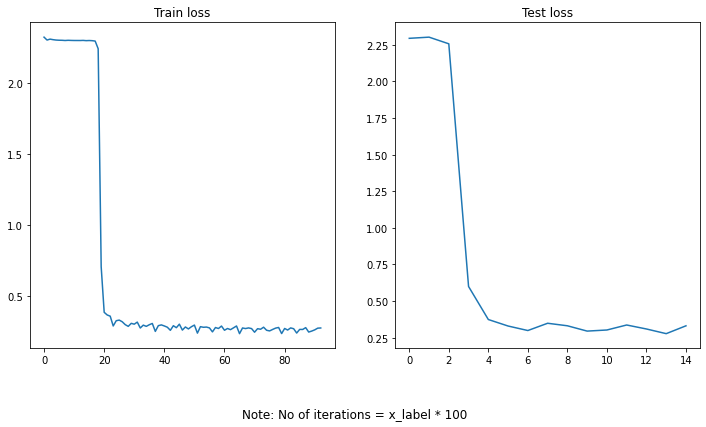

In [11]:
fig,ax = plt.subplots(ncols=2,figsize=(12,6))
fig.suptitle("Train and Test loss")
fig.suptitle(f'Note: No of iterations = x_label * {smooth_count}', y=-0.01)
ax[0].plot(average_over(train_loss,smooth_count))
ax[0].set_title("Train loss")
ax[1].plot(average_over(test_loss,smooth_count))
ax[1].set_title("Test loss")
plt.show()

##### Train and Test Accuracy

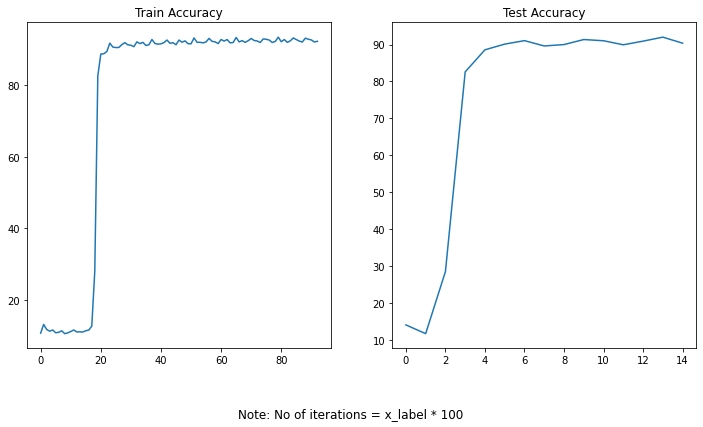

In [12]:
fig,ax = plt.subplots(ncols=2,figsize=(12,6))
fig.suptitle("Train and Test Accuracy")
fig.suptitle(f'Note: No of iterations = x_label * {smooth_count}', y=-0.01)
ax[0].plot(average_over(train_accuracy,smooth_count))
ax[0].set_title("Train Accuracy")
ax[1].plot(average_over(test_accuracy,smooth_count))
ax[1].set_title("Test Accuracy")
plt.show()